In [327]:
# import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import numpy as np


In [328]:
# import dataset
data = pd.read_csv(r'QVI_data.csv')
data.head()

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream
2,1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget
3,1003,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,NATURAL,YOUNG FAMILIES,Budget
4,1004,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream


In [329]:
data.shape

(264834, 12)

In [330]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264834 entries, 0 to 264833
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   LYLTY_CARD_NBR    264834 non-null  int64  
 1   DATE              264834 non-null  object 
 2   STORE_NBR         264834 non-null  int64  
 3   TXN_ID            264834 non-null  int64  
 4   PROD_NBR          264834 non-null  int64  
 5   PROD_NAME         264834 non-null  object 
 6   PROD_QTY          264834 non-null  int64  
 7   TOT_SALES         264834 non-null  float64
 8   PACK_SIZE         264834 non-null  int64  
 9   BRAND             264834 non-null  object 
 10  LIFESTAGE         264834 non-null  object 
 11  PREMIUM_CUSTOMER  264834 non-null  object 
dtypes: float64(1), int64(6), object(5)
memory usage: 24.2+ MB


### EXPLORATORY DATA ANALYSIS

In [331]:
# convert the DATE column to datetime format
data['DATE'] = pd.to_datetime(data['DATE'])

In [332]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264834 entries, 0 to 264833
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   LYLTY_CARD_NBR    264834 non-null  int64         
 1   DATE              264834 non-null  datetime64[ns]
 2   STORE_NBR         264834 non-null  int64         
 3   TXN_ID            264834 non-null  int64         
 4   PROD_NBR          264834 non-null  int64         
 5   PROD_NAME         264834 non-null  object        
 6   PROD_QTY          264834 non-null  int64         
 7   TOT_SALES         264834 non-null  float64       
 8   PACK_SIZE         264834 non-null  int64         
 9   BRAND             264834 non-null  object        
 10  LIFESTAGE         264834 non-null  object        
 11  PREMIUM_CUSTOMER  264834 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(6), object(4)
memory usage: 24.2+ MB


---
The client has selected stores **77**, **86**, and **88** as **trial stores** and would like us to identify suitable **control stores** for comparison.

To ensure a fair evaluation, control stores must meet the following criteria:

* Be operational for the entire **pre-trial period** (prior to **February 2019**).
* Show similar performance to the corresponding trial store in the following metrics:

  * **Monthly total sales revenue**
  * **Monthly number of customers**
  * **Monthly transactions per customer**

We will begin by calculating these metrics and filtering the data to include only stores that were consistently active during the pre-trial period.

---

---
#### *Creating the metrics of interest and filter to stores that are present throughout the pre-trial period*
---

In [334]:
# 1. Month ID
data['YEARMONTH'] = data['DATE'].dt.year * 100 + data['DATE'].dt.month

# 2. Per‑store‑per‑month measures
measure_over_time = (
    data
    .groupby(['STORE_NBR', 'YEARMONTH'])
    .agg(
        totSales         = ('TOT_SALES',  'sum'),
        nCustomers       = ('LYLTY_CARD_NBR', 'nunique'),
        nTxn             = ('TXN_ID', 'nunique'),
        totalChipsSold   = ('PROD_QTY', 'sum')
    )
    .reset_index()
)

# Derive ratios on the grouped frame so each row uses its own numerators/denominators
measure_over_time['nTxnPerCust']   = measure_over_time['nTxn'] / measure_over_time['nCustomers']
measure_over_time['nChipsPerTxn']  = measure_over_time['totalChipsSold'] / measure_over_time['nTxn']
measure_over_time['avgPricePerUnit'] = measure_over_time['totSales'] / measure_over_time['totalChipsSold']

# 3. Keep only stores with a full 12‑month history
stores_with_full_obs = (
    measure_over_time
    .groupby('STORE_NBR')
    .size()
    .loc[lambda s: s == 12]
    .index
)
# 4. Pre-trial subset
pre_trial_measures = measure_over_time[
    (measure_over_time['YEARMONTH'] < 201902) &
    (measure_over_time['STORE_NBR'].isin(stores_with_full_obs))
].copy()


---
#### *Next, we’ll rank how similar each potential control store is to a trial store by calculating the correlation in their performance over time. To streamline this, we’ll define a function so we can easily repeat the process for any trial–control store pair.*

---

In [335]:
def correlation_matrix(input_table, metric_col):
    """
    Calculates Pearson correlation between all stores
    based on their monthly performance for a given metric.
    
    Args:
        input_table (DataFrame): Should have STORE_NBR, YEARMONTH, and the metric_col.
        metric_col (str): The name of the metric to compare, e.g., 'totSales'.

    Returns:
        DataFrame: Correlation matrix where each value is the correlation
                   between two stores for the selected metric.
    """
    # Step 1: Convert the data to a wide format (rows = months, columns = store numbers)
    wide = input_table.pivot(index='YEARMONTH', columns='STORE_NBR', values=metric_col)

    # Step 2: Calculate correlation between every pair of store columns
    # method='pearson' is default; min_periods=1 avoids dropping pairs with a few missing values
    return wide.corr(method='pearson', min_periods=1)

# Example usage:
# 1. Call the function to compute all pairwise correlations for 'totSales'
corr_matrix = correlation_matrix(measure_over_time, 'totSales')

# 2. View the correlation matrix
print(corr_matrix.head())


STORE_NBR       1         2         3         4         5         6    \
STORE_NBR                                                               
1          1.000000 -0.195981  0.041121 -0.492948  0.058716  0.141821   
2         -0.195981  1.000000 -0.539074  0.058583 -0.649510 -0.154568   
3          0.041121 -0.539074  1.000000 -0.102727 -0.006704  0.024147   
4         -0.492948  0.058583 -0.102727  1.000000  0.340762 -0.007739   
5          0.058716 -0.649510 -0.006704  0.340762  1.000000 -0.022832   

STORE_NBR       7         8         9         10   ...       263       264  \
STORE_NBR                                          ...                       
1          0.251166 -0.661595 -0.063143  0.222589  ... -0.076844 -0.182779   
2          0.164764  0.390187  0.008657 -0.494245  ... -0.535434 -0.331516   
3          0.094842  0.127822 -0.135769  0.438298  ...  0.758825  0.066153   
4         -0.004379  0.499857  0.383188  0.298826  ...  0.100933  0.205588   
5         -0.017008 

In [336]:
# Example:
# Get correlation of Store 77 with all other stores
corr_with_77 = (
    corr_matrix.loc[77]          # Get the row for Store 77
    .drop(77)                    # Drop the self-comparison (correlation = 1.0)
    .reset_index()               # Turn index back into a column
    .rename(columns={'STORE_NBR': 'Store2', 77: 'corr_measure'})  # Clean column names
)

# Add a column to show it's being compared with Store 77
corr_with_77['Store1'] = 77

# Reorder columns for clarity
corr_with_77 = corr_with_77[['Store1', 'Store2', 'corr_measure']]

# View the results
print(corr_with_77.sort_values(by='corr_measure', ascending=False).head())


     Store1  Store2  corr_measure
30       77      31      1.000000
10       77      11      1.000000
40       77      41      0.762292
34       77      35      0.699708
165      77     167      0.696075


---

#### *In addition to using correlation, we can also measure similarity by calculating the standardized magnitude distance, based on the absolute difference between the trial store’s performance and each potential control store’s performance. Let’s create a function to automate this calculation.*
---

In [337]:
def calculate_magnitude_distance_v2(input_table, metric_col, store_comparison):
    """
    Calculates the average standardized magnitude distance between a trial store 
    and all other stores for a given performance metric using a vectorized approach.

    This method measures how similar each control store's trend is to the trial store
    by comparing the absolute differences in performance across time, scaling them 
    using min-max normalization per time period (YEARMONTH), and averaging the results.

    Args:
        input_table (pd.DataFrame): A long-format DataFrame with at least the following columns:
            - 'STORE_NBR': Store number
            - 'YEARMONTH': Integer in the format YYYYMM representing year and month
            - metric_col (str): The name of the column containing the metric to compare
        metric_col (str): Name of the performance metric column to compare (e.g., 'totSales')
        store_comparison (int): The store number of the trial store to compare against others

    Returns:
        pd.DataFrame: A DataFrame containing the average similarity scores for each store
                      compared to the trial store, with columns:
            - 'Store1': Trial store number (store_comparison)
            - 'Store2': Control store number
            - 'mag_measure': Standardized magnitude similarity score (higher = more similar)
    """

    # Step 1: Pivot the data into wide format
    pivot_df = input_table.pivot(index='YEARMONTH', columns='STORE_NBR', values=metric_col)

    # Step 2: Get trial store values
    trial_values = pivot_df[store_comparison]

    # Step 3: Compute absolute difference for all other stores
    abs_diff = pivot_df.subtract(trial_values, axis=0).abs()

    # Step 4: Min-max scale the distances by row (i.e., by YEARMONTH)
    min_vals = abs_diff.min(axis=1)
    max_vals = abs_diff.max(axis=1)
    range_vals = max_vals - min_vals

    # Avoid divide-by-zero
    standardized = 1 - ((abs_diff.subtract(min_vals, axis=0)).div(range_vals.replace(0, np.nan), axis=0))
    standardized = standardized.fillna(0)

    # Step 5: Average the scores across months (YEARMONTH)
    mag_scores = standardized.mean(axis=0).reset_index()
    mag_scores.columns = ['Store2', 'mag_measure']

    # Remove the trial store from results
    mag_scores = mag_scores[mag_scores['Store2'] != store_comparison]

    # Add Store1 column
    mag_scores['Store1'] = store_comparison

    # Reorder columns
    mag_scores = mag_scores[['Store1', 'Store2', 'mag_measure']]

    return mag_scores


In [338]:
# Compare total sales of store 77 to all other stores, based on their pre-trial behavior.
mag_distance_results_v2 = calculate_magnitude_distance_v2(pre_trial_measures, 'totSales', 77)

# View results
print(mag_distance_results_v2.sort_values(by='mag_measure', ascending=False).head())


     Store1  Store2  mag_measure
221      77     233     0.985265
242      77     255     0.976721
49       77      53     0.975422
180      77     188     0.975177
123      77     131     0.974959


---

#### *Now let’s identify suitable control stores using our similarity functions.*

#### *We’ll base the selection on how closely each store matches the trial stores in terms of:*

* monthly total sales (in dollar amounts), and
* monthly number of customers.

#### To do this, we’ll generate four similarity scores:
#### two from the correlation function and two from the magnitude distance function — one each for sales and customers.

---

In [339]:
def calculate_correlation(input_table: pd.DataFrame,
                          metric_col: str,
                          store_comparison: int) -> pd.DataFrame:
    """
    Compute pairwise correlation between a given store and all other stores
    for a specified metric.

    This function extracts the correlation values between the specified 
    store (`store_comparison`) and all other stores from a correlation 
    matrix of the given metric. It returns a tidy DataFrame suitable 
    for comparison and further analysis.

    Parameters
    ----------
    input_table : pd.DataFrame
        A DataFrame containing store-level metrics.
    metric_col : str
        The name of the column in `input_table` to compute correlations on.
    store_comparison : int
        The store number to compare against all other stores.

    Returns
    -------
    pd.DataFrame
        A tidy DataFrame with columns:
        - 'Store1': the store being compared (constant value `store_comparison`)
        - 'Store2': the other store in the pair
        - 'corr_measure': the correlation coefficient between Store1 and Store2

    Notes
    -----
    Uses `correlation_matrix()` defined earlier and returns a 
    square correlation matrix indexed by 'STORE_NBR'.
    """
    cm_row = correlation_matrix(input_table, metric_col).loc[store_comparison]
    return (
        cm_row.drop(store_comparison)
              .reset_index(name='corr_measure')
              .rename(columns={'STORE_NBR': 'Store2'})
              .assign(Store1 = store_comparison)
              [['Store1', 'Store2', 'corr_measure']]
    )

---
## Control Store Selection

#### *We're now applying the tested functions to select control stores that closely match each trial store’s pre-trial behavior.*

## 1. Trial Store 77

In [340]:
# Choose the trial store
trial_store = 77

# 1. Similarity by Pearson correlation
#    (uses the calculate_correlation() helper defined earlier)

corr_sales = calculate_correlation(
    input_table   = pre_trial_measures,
    metric_col    = 'totSales',
    store_comparison = trial_store
)

corr_customers = calculate_correlation(
    input_table   = pre_trial_measures,
    metric_col    = 'nCustomers',
    store_comparison = trial_store
)


# 2. Similarity by standardized magnitude distance
#    (uses the vectorised version: calculate_magnitude_distance_v2())

mag_sales = calculate_magnitude_distance_v2(
    input_table   = pre_trial_measures,
    metric_col    = 'totSales',
    store_comparison = trial_store
)

mag_customers = calculate_magnitude_distance_v2(
    input_table   = pre_trial_measures,
    metric_col    = 'nCustomers',
    store_comparison = trial_store
)

---
#### *Next, we’ll combine all the similarity scores into a single composite score to rank potential control stores.*
#### *We’ll calculate a simple average of the correlation and magnitude scores for each driver (i.e., total sales and number of customers).*

#### *If we want to prioritize stores with similar trends, we can assign a higher weight to the correlation score.*
#### *Alternatively, if we care more about matching the absolute values, we can reduce the correlation weight and emphasize the magnitude score.*

---

In [341]:
# Composite similarity score: combine correlation & magnitude

corr_weight = 0.3          # set to 0–1; raise if you care more about trend similarity

# Total sales
score_nSales = (
    pd.merge(corr_sales, mag_sales, on=['Store1', 'Store2'])          # join the two score tables
      .assign(                                                       # add composite score column
          score_nSales=lambda df: (
              df['corr_measure'] * corr_weight +
              df['mag_measure']  * (1 - corr_weight)
          )
      )
)

# Number of customers
score_nCustomers = (
    pd.merge(corr_customers, mag_customers, on=['Store1', 'Store2'])
      .assign(
          score_nCust=lambda df: (
              df['corr_measure'] * corr_weight +
              df['mag_measure']  * (1 - corr_weight)
          )
      )
)

# inspect the top‑ranked control stores
print(score_nSales.sort_values('score_nSales', ascending=False).head())
print(score_nCustomers.sort_values('score_nCust', ascending=False).head())


     Store1  Store2  corr_measure  mag_measure  score_nSales
220      77     233      0.903774     0.985265      0.960818
38       77      41      0.783232     0.965140      0.910568
46       77      50      0.763866     0.973129      0.910350
15       77      17      0.842668     0.880688      0.869282
158      77     167      0.657110     0.959133      0.868526
     Store1  Store2  corr_measure  mag_measure  score_nCust
220      77     233      0.990358     0.992773     0.992049
38       77      41      0.844219     0.974639     0.935513
240      77     254      0.916208     0.937131     0.930854
78       77      84      0.858571     0.924182     0.904499
15       77      17      0.747308     0.962495     0.897939


---
#### *Aggregate the driver‑level scores into one overall similarity score. We join the sales‑based and customer‑based composites on Store1 (trial) and Store2 (control), then take their simple average (equal weight 0.5 each) to produce a single finalControlScore. The higher the score, the better the candidate control store matches the trial store across both drivers.*
---

In [342]:
# Combine the sales‑ and customer‑level composite scores

score_control = (
    pd.merge(                                   # join on trial & control store IDs
        score_nSales[['Store1', 'Store2', 'score_nSales']],
        score_nCustomers[['Store1', 'Store2', 'score_nCust']],
        on=['Store1', 'Store2']
    )
    .assign(                                    # overall similarity (simple average)
        finalControlScore=lambda df: 0.3 * df['score_nSales'] +
                                    0.3 * df['score_nCust']
    )
)

# see the best‑matching control stores
print(score_control.sort_values('finalControlScore', ascending=False).head())


     Store1  Store2  score_nSales  score_nCust  finalControlScore
220      77     233      0.960818     0.992049           0.585860
38       77      41      0.910568     0.935513           0.553824
15       77      17      0.869282     0.897939           0.530166
107      77     115      0.859730     0.891806           0.525461
240      77     254      0.819072     0.930854           0.524978


---
#### *Select the control store with the highest overall similarity. For each trial store, sort the `finalControlScore` in descending order, ignore the trial store itself, and pick the top‑ranked candidate. The example below does this for trial store **77**.*
---

In [343]:
# Pick the best control store for the chosen trial store (77)

control_store = (
    score_control
      .query("Store1 == @trial_store and Store2 != @trial_store")   # keep pairs for this trial store, exclude self
      .sort_values('finalControlScore', ascending=False)            # highest score = best match
      .iloc[0]['Store2']                                            # take the top‑ranked control store
)

print(f"Best control store for trial store {trial_store}: {control_store}")


Best control store for trial store 77: 233.0


---
#### *Now that we've identified a control store **233** for **trial store 77**, it's important to visually confirm whether its performance trends are similar to the trial store's during the **pre-trial period**. We'll focus on total sales first. For each month, we'll categorize each store as either the **Trial store** (the one undergoing changes), the **Control store** (the one most similar to the trial store), or **Other stores** (all remaining stores).* 

#### *We’ll then calculate the average total sales for each group by month. If the sales trends of the trial and control stores closely align in this period, it validates that the control store is a good match for evaluating the trial’s impact.*
---

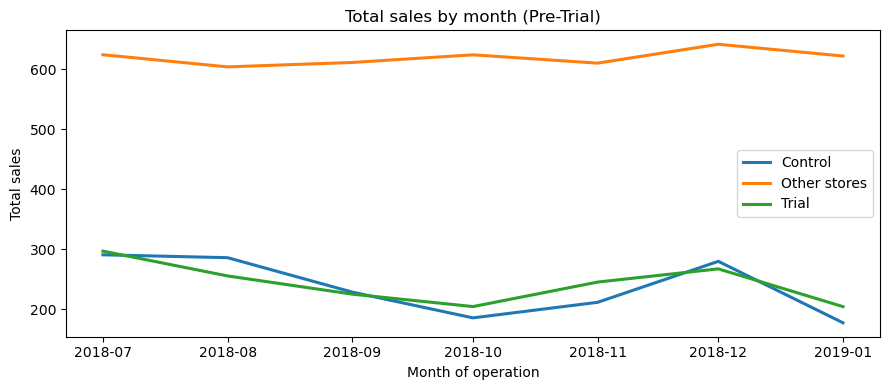

In [344]:
# 1 · Label each row as Trial, Control, or Other
measure_over_time['Store_type'] = np.select(
    [
        measure_over_time['STORE_NBR'] == trial_store,
        measure_over_time['STORE_NBR'] == control_store
    ],
    ['Trial', 'Control'],
    default='Other stores'
)


# 2 · Average total sales by month & store type
past_sales = (
    measure_over_time
      .groupby(['YEARMONTH', 'Store_type'], as_index=False)['totSales']
      .mean()
)


# 3 · Convert YEARMONTH → real date (first day of month)
past_sales['TransactionMonth'] = pd.to_datetime(
    past_sales['YEARMONTH'].astype(str) + '01', format='%Y%m%d'
)


# 4 · Keep only the pre‑trial window (before february‑2019)
past_sales = past_sales[past_sales['YEARMONTH'] < 201902]


# 5 · Plot
plt.figure(figsize=(9, 4))
for label, grp in past_sales.groupby('Store_type'):
    plt.plot(grp['TransactionMonth'], grp['totSales'], label=label, linewidth=2.2)

plt.xlabel('Month of operation')
plt.ylabel('Total sales')
plt.title('Total sales by month (Pre-Trial)')
plt.legend()
plt.tight_layout()
plt.show()


---
> Store **233** closely reflects Store **77**’s sales trend in the pre-trial period, supporting its selection as a reliable control for impact evaluation.
---

#### *let’s visually compare the trend of the number of customers between the trial store, control store, and other stores on the pre-trial period to confirm that customer trends were similar before the trial began.*
---

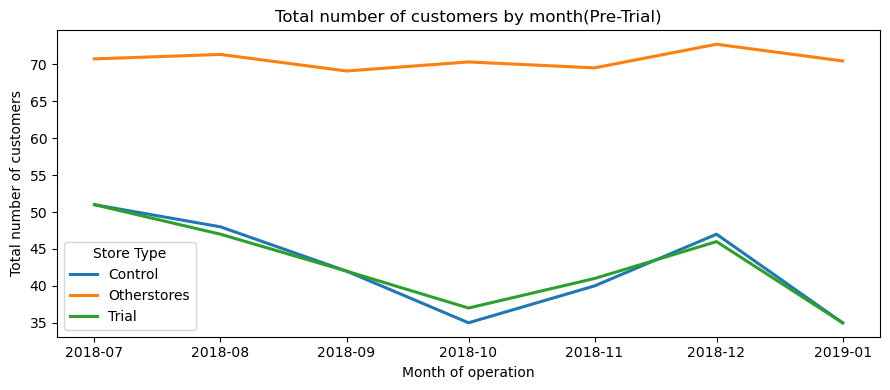

In [345]:
# Copy the original DataFrame
measure_over_time_custs = measure_over_time.copy()

# Assign store type labels
measure_over_time_custs["Store_type"] = measure_over_time_custs["STORE_NBR"].apply(
    lambda x: "Trial" if x == trial_store else "Control" if x == control_store else "Otherstores"
)

# Average number of customers by month and store type
past_customers = (
    measure_over_time_custs
    .groupby(["YEARMONTH", "Store_type"], as_index=False)
    .agg(numberCustomers=("nCustomers", "mean"))
)

# Create a TransactionMonth column for plotting
past_customers["TransactionMonth"] = pd.to_datetime(
    past_customers["YEARMONTH"].astype(str), format="%Y%m"
)

# Filter for pre-trial period (before february 2019)
past_customers = past_customers[past_customers["YEARMONTH"] < 201902]

# Plot the trends
plt.figure(figsize=(9, 4))
for label, df_group in past_customers.groupby("Store_type"):
    plt.plot(df_group["TransactionMonth"], df_group["numberCustomers"], label=label, linewidth=2.2)

plt.xlabel("Month of operation")
plt.ylabel("Total number of customers")
plt.title("Total number of customers by month(Pre-Trial)")
plt.legend(title="Store Type")
#plt.grid(True)
plt.tight_layout()
plt.show()


---
> The **control store 233** closely mirrors the **trial store’s 77** total customers trend during the pre-trial period, confirming its suitability for evaluating the impact.
---

### Assesment of Trial

The **trial period** spans from **February to April 2019**. To assess whether the trial led to an uplift in overall chip sales, we first adjusted the control store’s sales to account for baseline differences between it and the trial store prior to the trial. With both stores now on a comparable sales scale, we compute the monthly percentage differences between the trial store’s sales and the scaled control store’s sales during the trial period.

---

In [346]:
# 1 · SCALING FACTOR (pre‑trial totals)
trial_pre_tot  = pre_trial_measures.loc[
    pre_trial_measures['STORE_NBR'] == trial_store, 'totSales'
].sum()

control_pre_tot = pre_trial_measures.loc[
    pre_trial_measures['STORE_NBR'] == control_store, 'totSales'
].sum()

scaling_factor = trial_pre_tot / control_pre_tot
print(f"Scaling factor for control store sales: {scaling_factor:.4f}")

# 2 · APPLY THE FACTOR TO EVERY MONTH OF THE CONTROL STORE
scaled_control_sales = (
    measure_over_time[measure_over_time['STORE_NBR'] == control_store]
      .copy()
)
scaled_control_sales['controlSales'] = (
    scaled_control_sales['totSales'] * scaling_factor
)

# 3 · PERCENTAGE DIFFERENCE DURING THE TRIAL WINDOW (201902–201904)
trial_window = measure_over_time[
    (measure_over_time['STORE_NBR'] == trial_store) &
    (measure_over_time['YEARMONTH'].between(201902, 201904))
][['YEARMONTH', 'totSales']]

control_window = scaled_control_sales[
    scaled_control_sales['YEARMONTH'].between(201902, 201904)
][['YEARMONTH', 'controlSales']]

percentage_diff = (
    pd.merge(control_window, trial_window, on='YEARMONTH')
      .assign(
          percentageDiff=lambda df:
              (df['controlSales'] - df['totSales']).abs() / df['controlSales']
      )
)

print("\nPercentage difference (trial vs. scaled control):")
print(percentage_diff)


Scaling factor for control store sales: 1.0236

Percentage difference (trial vs. scaled control):
   YEARMONTH  controlSales  totSales  percentageDiff
0     201902    249.762622     235.0        0.059107
1     201903    203.802205     278.5        0.366521
2     201904    162.345704     263.5        0.623080


---
#### *To determine whether the observed difference in sales during the trial period is statistically significant, we perform a hypothesis test.*

#### *Assuming the ***null hypothesis that the trial period behavior is consistent with the pre-trial period (i.e., no difference)***, we calculate the standard deviation of the percentage differences between the trial and scaled control store during the pre-trial months. Using this, we compute the t-values for each trial month to assess significance.*

---

In [347]:
# 1 · Build percentage‑difference series for *all* months
trial_series = measure_over_time.loc[
    measure_over_time['STORE_NBR'] == trial_store,
    ['YEARMONTH', 'totSales']
]

control_series = scaled_control_sales[['YEARMONTH', 'controlSales']]

pct_diff_all = (
    pd.merge(control_series, trial_series, on='YEARMONTH')
      .assign(
          percentageDiff=lambda df:
              (df['controlSales'] - df['totSales']).abs() / df['controlSales']
      )
)


# 2 · Standard deviation from the pre‑trial window (< 201902)
pretrial_mask = pct_diff_all['YEARMONTH'] < 201902
std_dev = pct_diff_all.loc[pretrial_mask, 'percentageDiff'].std(ddof=1)

# Confirm 8 observations → 7 d.f.
degrees_of_freedom = pretrial_mask.sum() - 1
print(f"Pre‑trial σ = {std_dev:.4f}  |  df = {degrees_of_freedom}")


# 3 · Compute t‑values
pct_diff_all['tValue'] = pct_diff_all['percentageDiff'] / std_dev

# Human‑readable month label
pct_diff_all['TransactionMonth'] = pd.to_datetime(
    pct_diff_all['YEARMONTH'].astype(str), format='%Y%m'
)


# 4 · Extract trial‑period months for reporting (Feb – Apr 2019)
trial_tvals = pct_diff_all.loc[
    (pct_diff_all['YEARMONTH'] > 201901) & (pct_diff_all['YEARMONTH'] < 201905),
    ['TransactionMonth', 'tValue']
]

print("\nTrial‑period t‑values:")
print(trial_tvals.to_string(index=False))


Pre‑trial σ = 0.0499  |  df = 6

Trial‑period t‑values:
TransactionMonth    tValue
      2019-02-01  1.183534
      2019-03-01  7.339116
      2019-04-01 12.476373


---
#### *To determine whether the trial period changes are statistically significant, we compare the t-values to the critical value from the t-distribution at a 95% confidence level with 6 degrees of freedom.*
#### *This critical value represents the threshold beyond which we consider the difference unlikely to be due to random variation.*
---

In [348]:
from scipy.stats import t

# Given 6 degrees of freedom from earlier
critical_value = t.ppf(0.95, df=degrees_of_freedom)

print(f"Critical t-value at 95% confidence (df={degrees_of_freedom}): {critical_value:.4f}")


Critical t-value at 95% confidence (df=6): 1.9432


---
#### Insight:
> The t-values for March and April are **significantly higher than the 95th percentile** threshold of the t-distribution. This indicates that the **increase in sales** observed in the trial store during these months is **statistically significant** when compared to the control store, suggesting a genuine uplift in performance attributable to the trial intervention.
---

#### *To better understand the impact of the trial, we will create a visual comparison by plotting the sales performance of the trial store alongside the scaled sales of the control store. Additionally, we will overlay the 95th percentile threshold of the control store's sales to highlight periods where the trial store’s sales significantly exceeded expected levels.*
---

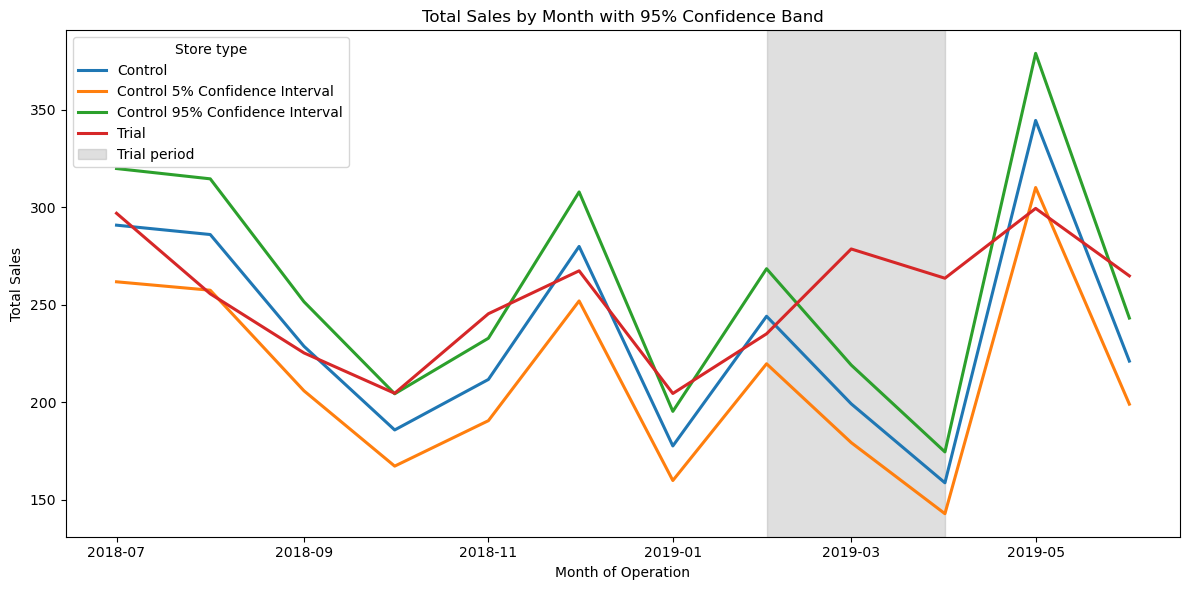

In [349]:
# STEP 1: Tag stores
past_sales = measure_over_time.copy()
past_sales['Store_type'] = past_sales['STORE_NBR'].apply(
    lambda x: 'Trial' if x == trial_store else ('Control' if x == control_store else 'Otherstores')
)

# STEP 2: Average sales per YEARMONTH & Store_type
past_sales = (
    past_sales.groupby(['YEARMONTH', 'Store_type'], as_index=False)['totSales']
    .mean()
)

# STEP 3: Create readable date
past_sales['TransactionMonth'] = pd.to_datetime(
    past_sales['YEARMONTH'].astype(str), format='%Y%m'
)

# Keep only Trial and Control
past_sales = past_sales[past_sales['Store_type'].isin(['Trial', 'Control'])]

# STEP 4: Create 95% and 5% confidence intervals
upper = past_sales[past_sales['Store_type'] == 'Control'].copy()
upper['totSales'] *= (1 + 2 * std_dev)
upper['Store_type'] = 'Control 95% Confidence Interval'

lower = past_sales[past_sales['Store_type'] == 'Control'].copy()
lower['totSales'] *= (1 - 2 * std_dev)
lower['Store_type'] = 'Control 5% Confidence Interval'

# STEP 5: Combine all into one DataFrame
trial_assessment = pd.concat([past_sales, upper, lower])

# STEP 6: Plot
plt.figure(figsize=(12, 6))
for label, df in trial_assessment.groupby('Store_type'):
    plt.plot(df['TransactionMonth'], df['totSales'], label=label, linewidth=2.2)

# Create custom patch for the shaded area (in case it's not picked up by axvspan's label)
trial_patch = mpatches.Patch(color='grey', alpha=0.25, label='Trial period')

# Highlight the trial period: Feb to Apr 2019
trial_start = trial_assessment[trial_assessment["YEARMONTH"] == 201902]["TransactionMonth"].min()
trial_end = trial_assessment[trial_assessment["YEARMONTH"] == 201904]["TransactionMonth"].max()

plt.axvspan(trial_start, trial_end, color="grey", alpha=0.25)

plt.xlabel("Month of Operation")
plt.ylabel("Total Sales")
plt.title("Total Sales by Month with 95% Confidence Band")
plt.legend(title="Store type", handles=[*plt.gca().get_legend_handles_labels()[0], trial_patch])
plt.tight_layout()
plt.show()


---
#### Insight:
> During the trial period ***(Feb–Apr 2019)***, **Store 77**’s total sales consistently **exceeded** the upper bound of **the 95% confidence interval** derived from **control store 233** in two of the three months. This indicates **a statistically significant uplift in sales**, suggesting that the trial had a positive and measurable effect on purchase behavior, resulting in higher-than-expected revenue performance compared to normal conditions.
---

#### *Assessing this for number of customers as well.*

In [350]:
# 1 · SCALE pre‑trial control customers to match trial customers
trial_pre_cust = pre_trial_measures.loc[
    (pre_trial_measures["STORE_NBR"] == trial_store) &
    (pre_trial_measures["YEARMONTH"] < 201902),
    "nCustomers"
].sum()

control_pre_cust = pre_trial_measures.loc[
    (pre_trial_measures["STORE_NBR"] == control_store) &
    (pre_trial_measures["YEARMONTH"] < 201902),
    "nCustomers"
].sum()

scaling_factor_cust = trial_pre_cust / control_pre_cust
print(f"Customer‑scaling factor: {scaling_factor_cust:.4f}")

# 2 · Apply scaling factor to every month of the control store
measure_over_time_custs = measure_over_time.copy()

scaled_control_custs = measure_over_time_custs[
    measure_over_time_custs["STORE_NBR"] == control_store
].copy()

scaled_control_custs["controlCustomers"] = (
    scaled_control_custs["nCustomers"] * scaling_factor_cust
)

# Optional Store_type tag (matches R logic, though not needed for %‑diff calc)
scaled_control_custs["Store_type"] = "Control"
measure_over_time_custs.loc[
    measure_over_time_custs["STORE_NBR"] == trial_store, "Store_type"
] = "Trial"

# 3 · Percentage difference each month (Trial vs. scaled Control)
trial_cust_series = measure_over_time_custs[
    measure_over_time_custs["STORE_NBR"] == trial_store
][["YEARMONTH", "nCustomers"]]

percentage_diff_cust = (
    pd.merge(
        scaled_control_custs[["YEARMONTH", "controlCustomers"]],
        trial_cust_series,
        on="YEARMONTH"
    )
    .assign(
        percentageDiff=lambda df:
            (df["controlCustomers"] - df["nCustomers"]).abs() /
            df["controlCustomers"]
    )
)

print("\nPercentage difference (customers):")
print(percentage_diff_cust.head())


Customer‑scaling factor: 1.0034

Percentage difference (customers):
   YEARMONTH  controlCustomers  nCustomers  percentageDiff
0     201807         51.171141          51        0.003344
1     201808         48.161074          47        0.024108
2     201809         42.140940          42        0.003344
3     201810         35.117450          37        0.053607
4     201811         40.134228          41        0.021572


Pre‑trial σ (customers) = 0.0182  |  df = 6


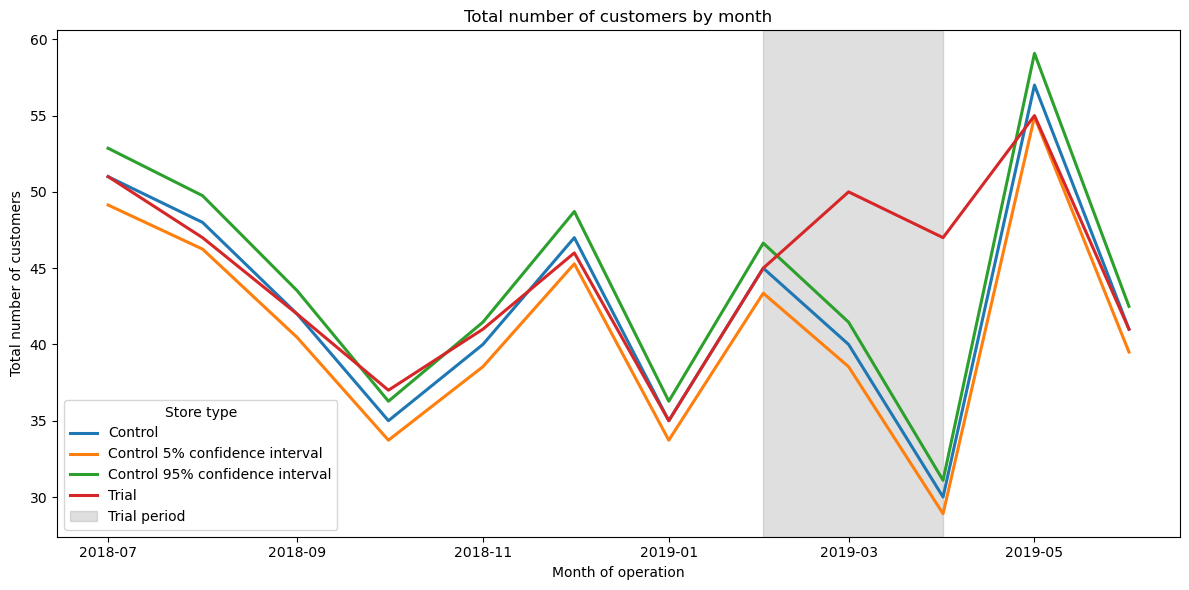

In [351]:
# 1 · σ (stdDev) of %‑diff in the pre‑trial window (< 201902)
std_dev_cust = percentage_diff_cust.loc[
    percentage_diff_cust["YEARMONTH"] < 201902, "percentageDiff"
].std(ddof=1)
degrees_of_freedom_cust = degrees_of_freedom   # as defined earlier

print(f"Pre‑trial σ (customers) = {std_dev_cust:.4f}  |  df = 6")


# 2 · Mean monthly customers by store type
mc = measure_over_time_custs.copy()
mc["Store_type"] = np.select(
    [mc["STORE_NBR"] == trial_store, mc["STORE_NBR"] == control_store],
    ["Trial", "Control"],
    default="Otherstores"
)

past_customers = (
    mc.groupby(["YEARMONTH", "Store_type"], as_index=False)["nCustomers"]
      .mean()
      .rename(columns={"nCustomers": "nCusts"})
)

# First‑of‑month date for plotting
past_customers["TransactionMonth"] = pd.to_datetime(
    past_customers["YEARMONTH"].astype(str), format="%Y%m"
)

# Keep only Trial & Control
past_customers = past_customers[past_customers["Store_type"].isin(["Trial", "Control"])]


# 3 · ± 2 σ multiplicative bounds for the Control line
c95 = past_customers[past_customers["Store_type"] == "Control"].copy()
c95["nCusts"] *= (1 + 2 * std_dev_cust)
c95["Store_type"] = "Control 95% confidence interval"

c05 = past_customers[past_customers["Store_type"] == "Control"].copy()
c05["nCusts"] *= (1 - 2 * std_dev_cust)
c05["Store_type"] = "Control 5% confidence interval"

# Combine
trial_assessment_cust = pd.concat([past_customers, c95, c05], ignore_index=True)


# 4 · Plot
plt.figure(figsize=(12, 6))

# Shade Feb–Apr 2019
trial_start = trial_assessment_cust[trial_assessment_cust["YEARMONTH"] == 201902]["TransactionMonth"].min()
trial_end = trial_assessment_cust[trial_assessment_cust["YEARMONTH"] == 201904]["TransactionMonth"].max()

plt.axvspan(trial_start, trial_end, color="grey", alpha=0.25)

# Plot each line
for label, grp in trial_assessment_cust.groupby("Store_type"):
    plt.plot(grp["TransactionMonth"], grp["nCusts"], label=label, linewidth=2.2)

# Create custom patch for the shaded area (in case it's not picked up by axvspan's label)
trial_patch = mpatches.Patch(color='grey', alpha=0.25, label='Trial period')

plt.title("Total number of customers by month")
plt.xlabel("Month of operation")
plt.ylabel("Total number of customers")
plt.legend(title="Store type", handles=[*plt.gca().get_legend_handles_labels()[0], trial_patch])
plt.tight_layout()
plt.show()


---
#### Insight:

> The consistent rise in customer numbers above the **95% confidence interval** during the trial period (*except for a slight drop in February*) indicates that **the trial had a positive and statistically significant impact** on customer engagement. This sharp upward shift suggests the intervention was effective in attracting more customers than would be expected under normal conditions.
---

## 2. Trial Store 86

In [352]:
trial_store = 86        # set current trial store

# 1 · Similarity by correlation  (sales & customers)
corr_nSales = calculate_correlation(pre_trial_measures, 'totSales',   trial_store)
corr_nCustomers = calculate_correlation(pre_trial_measures, 'nCustomers', trial_store)


# 2 · Similarity by magnitude distance  (sales & customers)
magn_nSales = calculate_magnitude_distance_v2(pre_trial_measures, 'totSales',   trial_store)
magn_nCustomers = calculate_magnitude_distance_v2(pre_trial_measures, 'nCustomers', trial_store)


# 3 · Combine correlation & magnitude for each driver
corr_weight = 0.5  # simple average, same as R

score_nSales = (
    pd.merge(corr_nSales, magn_nSales, on=['Store1', 'Store2'])
      .assign(
          scoreNSales=lambda df:
              df['corr_measure'] * corr_weight +
              df['mag_measure']  * (1 - corr_weight)
      )
)

score_nCustomers = (
    pd.merge(corr_nCustomers, magn_nCustomers, on=['Store1', 'Store2'])
      .assign(
          scoreNCust=lambda df:
              df['corr_measure'] * corr_weight +
              df['mag_measure']  * (1 - corr_weight)
      )
)


# 4 · Final composite score across both drivers
score_control = (
    pd.merge(score_nSales[['Store1', 'Store2', 'scoreNSales']],
             score_nCustomers[['Store1', 'Store2', 'scoreNCust']],
             on=['Store1', 'Store2'])
      .assign(finalControlScore=lambda df:
              0.5 * df['scoreNSales'] + 0.5 * df['scoreNCust'])
)


# 5 · Select best control store for trial store 86
control_store = (
    score_control.query("Store1 == @trial_store")
                 .sort_values('finalControlScore', ascending=False)
                 .iloc[0]['Store2']
)

print(f"Chosen control store for trial store {trial_store}: {int(control_store)}")


Chosen control store for trial store 86: 155


---
#### Insight:

> **Store 155** appears to be the **best match** to serve as the **control store** for **trial store 86**. As with the previous trial, let’s now take a visual look at the drivers to confirm whether their patterns were indeed similar in the pre-trial period.
---
#### *We start with total sales.*


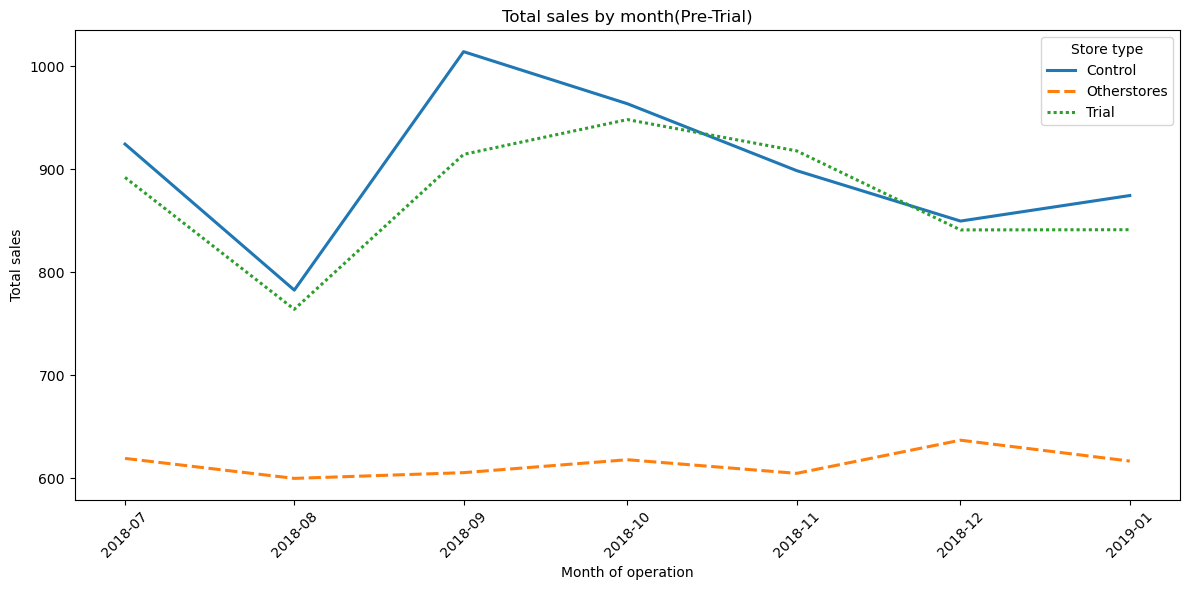

In [353]:
# 1.  Flag each row: Trial / Control / Other
mos = measure_over_time.copy()
mos["Store_type"] = mos["STORE_NBR"].map(
    lambda s: "Trial" if s == trial_store else
              "Control" if s == control_store else
              "Otherstores"
)

# 2.  Mean monthly sales by YEARMONTH & Store_type
past_sales = (
    mos.groupby(["YEARMONTH", "Store_type"], as_index=False)["totSales"]
       .mean()
)

# 3.  First‑of‑month date for plotting
past_sales["TransactionMonth"] = pd.to_datetime(
    past_sales["YEARMONTH"].astype(str), format="%Y%m"
)

# 4.  Keep the pre‑trial window (YEARMONTH < 201902)
past_sales = past_sales[past_sales["YEARMONTH"] < 201902]

# 5.  Plot
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=past_sales,
    x="TransactionMonth",
    y="totSales",
    hue="Store_type",
    style="Store_type",              # line types match colors
    linewidth=2.2
)

plt.title("Total sales by month(Pre-Trial)")
plt.xlabel("Month of operation")
plt.ylabel("Total sales")
plt.xticks(rotation=45)
plt.legend(title="Store type")
plt.tight_layout()
plt.show()


---
> The total sales trends for **trial store 86** and its **control store 155** are **closely aligned** in the pre-trial period, indicating strong similarity in their baseline performance.
---
#### *Let’s now take a look at the number of customers.*

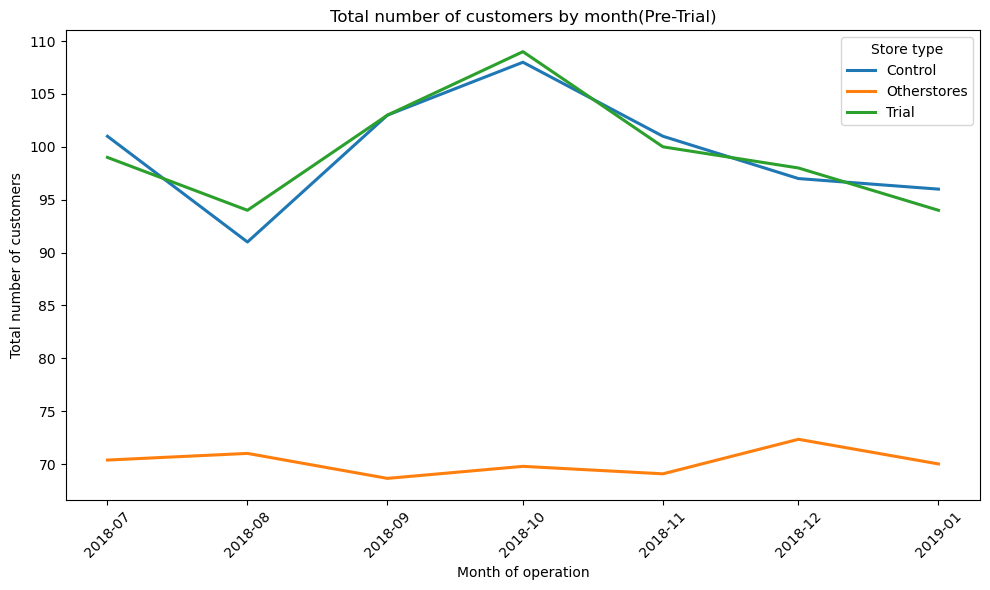

In [354]:
# Add Store_type classification
measure_over_time_custs = measure_over_time.copy()
measure_over_time_custs['Store_type'] = measure_over_time_custs['STORE_NBR'].apply(
    lambda x: 'Trial' if x == trial_store else 'Control' if x == control_store else 'Otherstores'
)

# Compute mean number of customers by YEARMONTH and Store_type
past_customers = (
    measure_over_time_custs.groupby(['YEARMONTH', 'Store_type'], as_index=False)
    .agg(numberCustomers=('nCustomers', 'mean'))
)

# Add TransactionMonth for proper x-axis formatting
past_customers['TransactionMonth'] = pd.to_datetime(
    past_customers['YEARMONTH'].astype(str), format='%Y%m'
)

# Filter pre-trial months
past_customers = past_customers[past_customers['YEARMONTH'] < 201902]


plt.figure(figsize=(10, 6))
for label, grp in past_customers.groupby("Store_type"):
    plt.plot(grp["TransactionMonth"], grp["numberCustomers"], label=label, linewidth=2.2)

plt.title("Total number of customers by month(Pre-Trial)")
plt.xlabel("Month of operation")
plt.ylabel("Total number of customers")
plt.xticks(rotation=45)
plt.legend(title="Store type")
plt.tight_layout()
plt.show()


---
> Customer counts also show a similar trend between the **trial 86** and **control store 155**, reinforcing their comparability.
---
#### *Let's move on to evaluating the trial's impact on sales.*


### Assesment of Trial

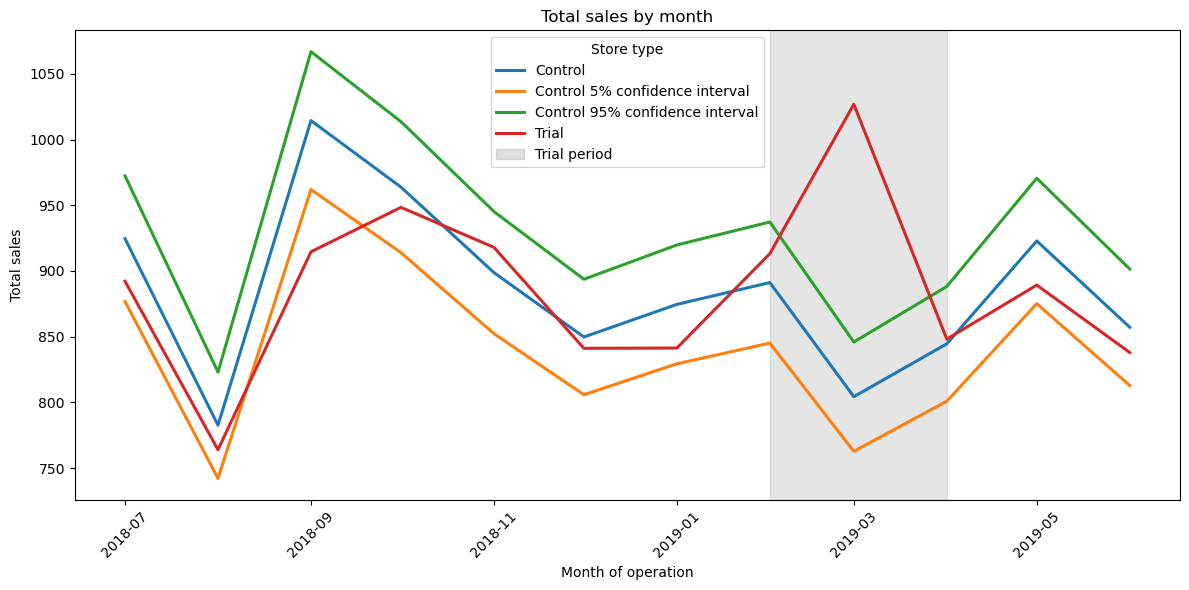

In [355]:
# Step 1: Calculate scaling factor for control store sales
scaling_factor_sales = (
    pre_trial_measures[
        (pre_trial_measures["STORE_NBR"] == trial_store) &
        (pre_trial_measures["YEARMONTH"] < 201902)
    ]["totSales"].sum()
    /
    pre_trial_measures[
        (pre_trial_measures["STORE_NBR"] == control_store) &
        (pre_trial_measures["YEARMONTH"] < 201902)
    ]["totSales"].sum()
)

# Step 2: Apply the scaling factor to the control store sales
scaled_control_sales = (
    measure_over_time[measure_over_time["STORE_NBR"] == control_store]
    .copy()
)
scaled_control_sales["controlSales"] = scaled_control_sales["totSales"] * scaling_factor_sales

# Step 3: Calculate the percentage difference between scaled control and trial sales
trial_sales = (
    measure_over_time[measure_over_time["STORE_NBR"] == trial_store]
    [["YEARMONTH", "totSales"]]
)

percentage_diff = pd.merge(
    scaled_control_sales[["YEARMONTH", "controlSales"]],
    trial_sales,
    on="YEARMONTH"
)
percentage_diff["percentageDiff"] = (
    (percentage_diff["controlSales"] - percentage_diff["totSales"]).abs()
    / percentage_diff["controlSales"]
)

# Step 4: Calculate standard deviation of percentage difference in pre-trial
std_dev = percentage_diff[percentage_diff["YEARMONTH"] < 201902]["percentageDiff"].std()
degrees_of_freedom = degrees_of_freedom

# Step 5: Create data for plotting
plot_df = measure_over_time.copy()
plot_df["Store_type"] = plot_df["STORE_NBR"].apply(
    lambda x: "Trial" if x == trial_store else ("Control" if x == control_store else "Otherstores")
)

# Step 6: Group and prepare plot data
past_sales = (
    plot_df
    .groupby(["YEARMONTH", "Store_type"], as_index=False)["totSales"]
    .mean()
)
past_sales["TransactionMonth"] = pd.to_datetime(
    past_sales["YEARMONTH"].astype(str).str[:4] + "-" +
    past_sales["YEARMONTH"].astype(str).str[4:] + "-01"
)

past_sales = past_sales[past_sales["Store_type"].isin(["Trial", "Control"])].copy()

# Step 7: Create confidence intervals
controls_95 = past_sales[past_sales["Store_type"] == "Control"].copy()
controls_95["totSales"] = controls_95["totSales"] * (1 + std_dev * 2)
controls_95["Store_type"] = "Control 95% confidence interval"

controls_5 = past_sales[past_sales["Store_type"] == "Control"].copy()
controls_5["totSales"] = controls_5["totSales"] * (1 - std_dev * 2)
controls_5["Store_type"] = "Control 5% confidence interval"

# Step 8: Combine for final plot
trial_assessment = pd.concat([past_sales, controls_95, controls_5])

# Step 9: Plotting
plt.figure(figsize=(12, 6))

# Highlight trial period
trial_period = trial_assessment[
    (trial_assessment["YEARMONTH"] > 201901) & (trial_assessment["YEARMONTH"] < 201905)
]
plt.axvspan(trial_period["TransactionMonth"].min(),
            trial_period["TransactionMonth"].max(),
            color="grey", alpha=0.2)

# Plot lines
for label, grp in trial_assessment.groupby("Store_type"):
    plt.plot(grp["TransactionMonth"], grp["totSales"], label=label, linewidth=2.2)

# Create custom patch for the shaded area (in case it's not picked up by axvspan's label)
trial_patch = mpatches.Patch(color='grey', alpha=0.25, label='Trial period')

plt.title("Total sales by month")
plt.xlabel("Month of operation")
plt.ylabel("Total sales")
plt.xticks(rotation=45)
plt.legend(title="Store type", handles=[*plt.gca().get_legend_handles_labels()[0], trial_patch])
plt.tight_layout()
plt.show()


---
#### Insight:
> The results suggest that the trial in Store **86** may have had a **positive impact on total sales**, particularly in **March 2019**, where the trial store's performance **exceeded the 95% confidence interval** of the control store. However, in **February and April**, the trial store's sales remained **within or close to** the control store’s expected range, indicating a **mixed but possibly upward trend** due to the trial.
---

#### *Let’s now evaluate the number of customers to see if similar patterns hold.*


Scaling factor (customers): 1.0000
Pre‑trial σ (customers) = 0.0107 | df = 6


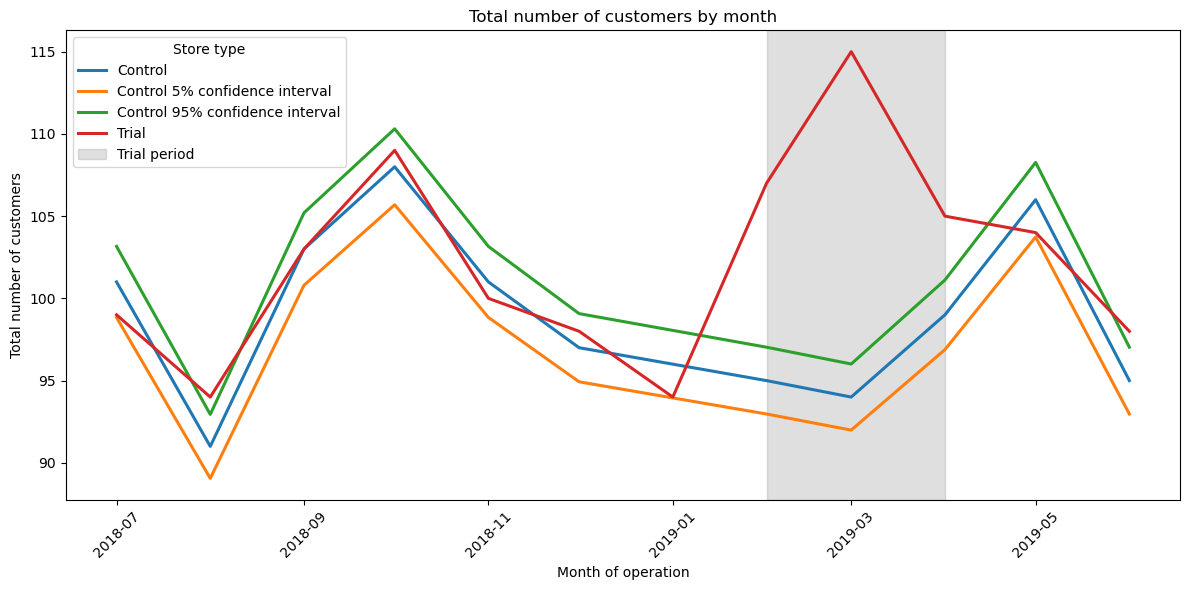

In [356]:
# 1 · Scaling factor to align pre‑trial customers
trial_pre_cust = (
    pre_trial_measures
      .loc[(pre_trial_measures["STORE_NBR"] == trial_store) &
           (pre_trial_measures["YEARMONTH"] < 201902), "nCustomers"]
      .sum()
)
control_pre_cust = (
    pre_trial_measures
      .loc[(pre_trial_measures["STORE_NBR"] == control_store) &
           (pre_trial_measures["YEARMONTH"] < 201902), "nCustomers"]
      .sum()
)
scaling_factor_cust = trial_pre_cust / control_pre_cust
print(f"Scaling factor (customers): {scaling_factor_cust:.4f}")


# 2 · Apply scaling factor to every month of the control store

scaled_control_cust = (
    measure_over_time[measure_over_time["STORE_NBR"] == control_store]
      .copy()
)
scaled_control_cust["controlCustomers"] = (
    scaled_control_cust["nCustomers"] * scaling_factor_cust
)


# 3 · Percentage‑difference series

trial_cust_series = measure_over_time[
    measure_over_time["STORE_NBR"] == trial_store
][["YEARMONTH", "nCustomers"]]

percentage_diff_cust = (
    pd.merge(
        scaled_control_cust[["YEARMONTH", "controlCustomers"]],
        trial_cust_series,
        on="YEARMONTH"
    )
    .assign(
        percentageDiff=lambda df:
            (df["controlCustomers"] - df["nCustomers"]).abs() / df["controlCustomers"]
    )
)


# 4 · Std‑dev of %‑diff in the pre‑trial window (< 201902)
std_dev_cust = percentage_diff_cust.loc[
    percentage_diff_cust["YEARMONTH"] < 201902, "percentageDiff"
].std(ddof=1)
print(f"Pre‑trial σ (customers) = {std_dev_cust:.4f} | df = {degrees_of_freedom}")


# 5 · Prepare monthly averages for plotting

mos = measure_over_time.copy()
mos["Store_type"] = np.select(
    [mos["STORE_NBR"] == trial_store,
     mos["STORE_NBR"] == control_store],
    ["Trial", "Control"],
    default="Otherstores"
)

past_customers = (
    mos.groupby(["YEARMONTH", "Store_type"], as_index=False)["nCustomers"]
       .mean()
       .rename(columns={"nCustomers": "nCusts"})
)
past_customers["TransactionMonth"] = pd.to_datetime(
    past_customers["YEARMONTH"].astype(str), format="%Y%m"
)
past_customers = past_customers[past_customers["Store_type"].isin(["Trial", "Control"])]


# 6 · Build multiplicative ± 2 σ bounds for control line
c95 = past_customers[past_customers["Store_type"] == "Control"].copy()
c05 = c95.copy()
c95["nCusts"] *= (1 + 2 * std_dev_cust)
c05["nCusts"] *= (1 - 2 * std_dev_cust)
c95["Store_type"] = "Control 95% confidence interval"
c05["Store_type"] = "Control 5% confidence interval"

# Combine for plotting
plot_df = pd.concat([past_customers, c95, c05], ignore_index=True)


# 7 · Plot
plt.figure(figsize=(12, 6))

# Shade the trial window (Feb–Apr 2019)
trial_start = plot_df[plot_df["YEARMONTH"] == 201902]["TransactionMonth"].min()
trial_end = plot_df[plot_df["YEARMONTH"] == 201904]["TransactionMonth"].max()

plt.axvspan(trial_start, trial_end, color="grey", alpha=0.25)

# Plot each line
for label, grp in plot_df.groupby("Store_type"):
    plt.plot(grp["TransactionMonth"], grp["nCusts"], label=label, linewidth=2.2)

# Create custom patch for the shaded area (in case it's not picked up by axvspan's label)
trial_patch = mpatches.Patch(color='grey', alpha=0.25, label='Trial period')

plt.title("Total number of customers by month")
plt.xlabel("Month of operation")
plt.ylabel("Total number of customers")
plt.xticks(rotation=45)
plt.legend(title="Store type", handles=[*plt.gca().get_legend_handles_labels()[0], trial_patch])
plt.tight_layout()
plt.show()


---
#### Insight:
> During the trial period (***February to April 2019***), the trial store **86** experienced a noticeable increase in the number of customers compared to its pre-trial performance. The red line representing the trial store consistently remained above the control store's average (blue line) and, for all three trial months, stayed above the **upper bound of the 95% confidence interval** (green line) calculated from the control store's pre-trial variation.
This suggests that the uplift in customer numbers at the trial store is **statistically significant and not due to random fluctuation.** Therefore, the trial intervention appears to have positively impacted customer footfall during the trial period.
---

## 3. Trial Store 88

In [357]:
trial_store = 88        # set current trial store

# 1 · Similarity based on correlation
corr_nSales     = calculate_correlation(pre_trial_measures, 'totSales',   trial_store)
corr_nCustomers = calculate_correlation(pre_trial_measures, 'nCustomers', trial_store)

# 2 · Similarity based on magnitude distance
magn_nSales     = calculate_magnitude_distance_v2(pre_trial_measures, 'totSales',   trial_store)
magn_nCustomers = calculate_magnitude_distance_v2(pre_trial_measures, 'nCustomers', trial_store)

# 3 · Combine correlation & magnitude for each driver
corr_weight = 0.5       # simple average 

score_nSales = (
    pd.merge(corr_nSales, magn_nSales, on=['Store1', 'Store2'])
      .assign(scoreNSales=lambda df:
              df['corr_measure'] * corr_weight +
              df['mag_measure']  * (1 - corr_weight))
)

score_nCustomers = (
    pd.merge(corr_nCustomers, magn_nCustomers, on=['Store1', 'Store2'])
      .assign(scoreNCust=lambda df:
              df['corr_measure'] * corr_weight +
              df['mag_measure']  * (1 - corr_weight))
)

# 4 · Final composite score across both drivers
score_control = (
    pd.merge(score_nSales[['Store1', 'Store2', 'scoreNSales']],
             score_nCustomers[['Store1', 'Store2', 'scoreNCust']],
             on=['Store1', 'Store2'])
      .assign(finalControlScore=lambda df:
              0.5 * df['scoreNSales'] + 0.5 * df['scoreNCust'])
)

# 5 · Select control store
best_match = (
    score_control.query("Store1 == @trial_store")
                 .sort_values('finalControlScore', ascending=False)
)

# If the trial store is excluded in similarity tables (default) → use .iloc[0]
control_store = best_match.iloc[0]['Store2']

print(f"Control store selected for trial store {trial_store}: {int(control_store)}")


Control store selected for trial store 88: 237


---
#### Insight:
> Store **237** has been identified as the most appropriate **control store** for **trial store 88**. Let’s now do a visual check to confirm that the key performance drivers show similar patterns in the pre-trial period.
---

#### *We’ll begin by examining total sales.*

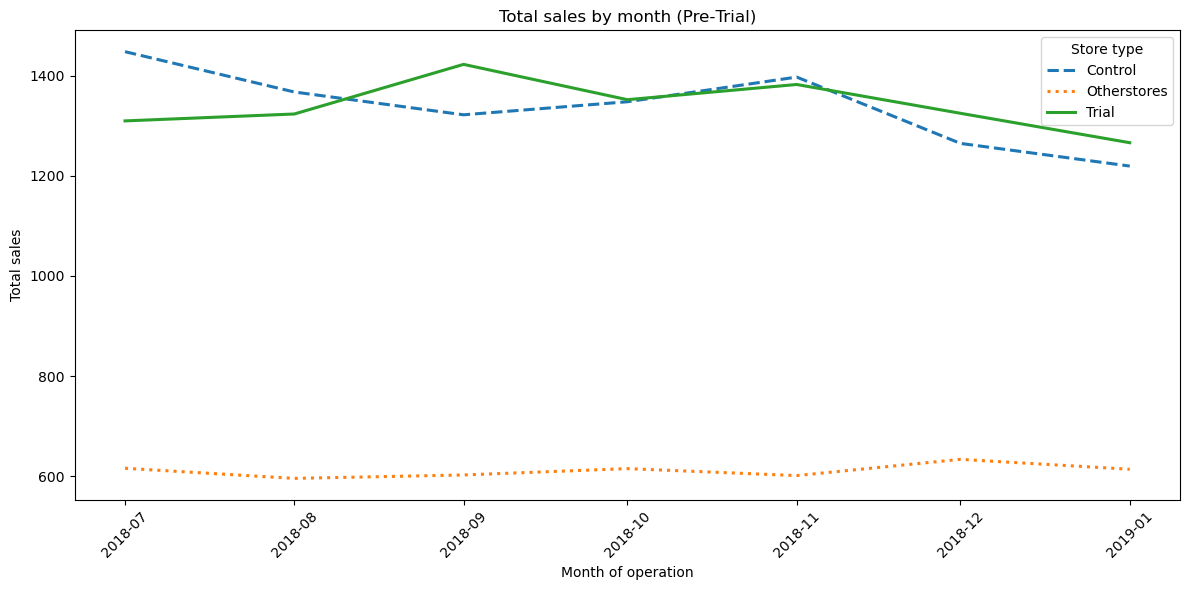

In [358]:
# 1 · Label each row as Trial / Control / Otherstores
sales_df = measure_over_time.copy()
sales_df["Store_type"] = sales_df["STORE_NBR"].apply(
    lambda s: "Trial" if s == trial_store else
              "Control" if s == control_store else
              "Otherstores"
)

# 2 · Compute mean monthly sales by YEARMONTH & Store_type
past_sales = (
    sales_df.groupby(["YEARMONTH", "Store_type"], as_index=False)["totSales"]
            .mean()
)

# 3 · Add a real date column for the x‑axis
past_sales["TransactionMonth"] = pd.to_datetime(
    past_sales["YEARMONTH"].astype(str), format="%Y%m"
)

# 4 · Keep only the pre‑trial window (before March 2019)
past_sales = past_sales[past_sales["YEARMONTH"] < 201902]

# 5 · Plot
plt.figure(figsize=(12, 6))

linestyle_map = {"Trial": "-", "Control": "--", "Otherstores": ":"}

for label, grp in past_sales.groupby("Store_type"):
    plt.plot(
        grp["TransactionMonth"],
        grp["totSales"],
        label=label,
        linestyle=linestyle_map.get(label, "-"),
        linewidth=2.2
    )

plt.title("Total sales by month (Pre‑Trial)")
plt.xlabel("Month of operation")
plt.ylabel("Total sales")
plt.xticks(rotation=45)
plt.legend(title="Store type")
plt.tight_layout()
plt.show()


---
> Total sales for **trial store 88** and **control store 237** show a strong alignment in their pre-trial trends, indicating they are well matched for comparison. 
---
#### *Let's now examine the number of customers.*

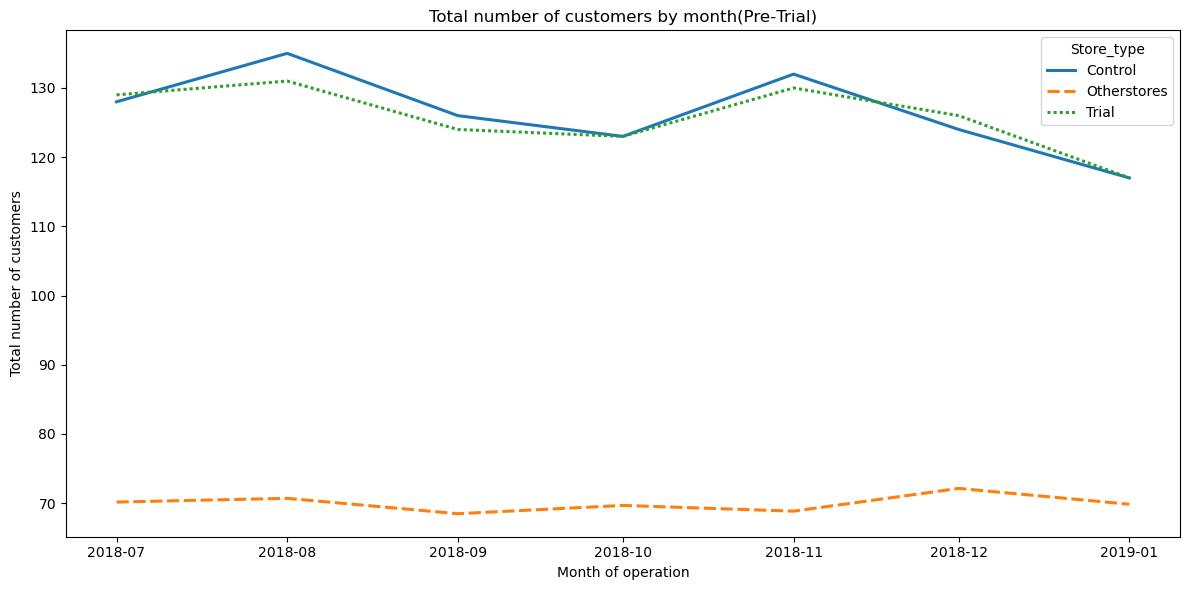

In [359]:
# Create a copy
measureOverTimeCusts = measure_over_time.copy()

# Assign store type
measureOverTimeCusts["Store_type"] = measureOverTimeCusts["STORE_NBR"].apply(
    lambda x: "Trial" if x == trial_store else "Control" if x == control_store else "Otherstores"
)

# Calculate monthly average number of customers per store type
pastCustomers = (
    measureOverTimeCusts[measureOverTimeCusts["YEARMONTH"] < 201902]
    .groupby(["YEARMONTH", "Store_type"])["nCustomers"]
    .mean()
    .reset_index(name="numberCustomers")
)

# Create a proper date column from YEARMONTH
pastCustomers["TransactionMonth"] = pd.to_datetime(
    pastCustomers["YEARMONTH"].astype(str), format="%Y%m"
)

# Plotting
plt.figure(figsize=(12, 6))
sns.lineplot(data=pastCustomers, x="TransactionMonth", y="numberCustomers", hue="Store_type", style="Store_type", linewidth=2.2)
plt.title("Total number of customers by month(Pre‑Trial)")
plt.xlabel("Month of operation")
plt.ylabel("Total number of customers")
plt.tight_layout()
plt.show()


---
> The number of customers in the **trial 88** and **control store 237** also follow a similar pattern, reinforcing their suitability for comparison.
---

### Assessment of Trial

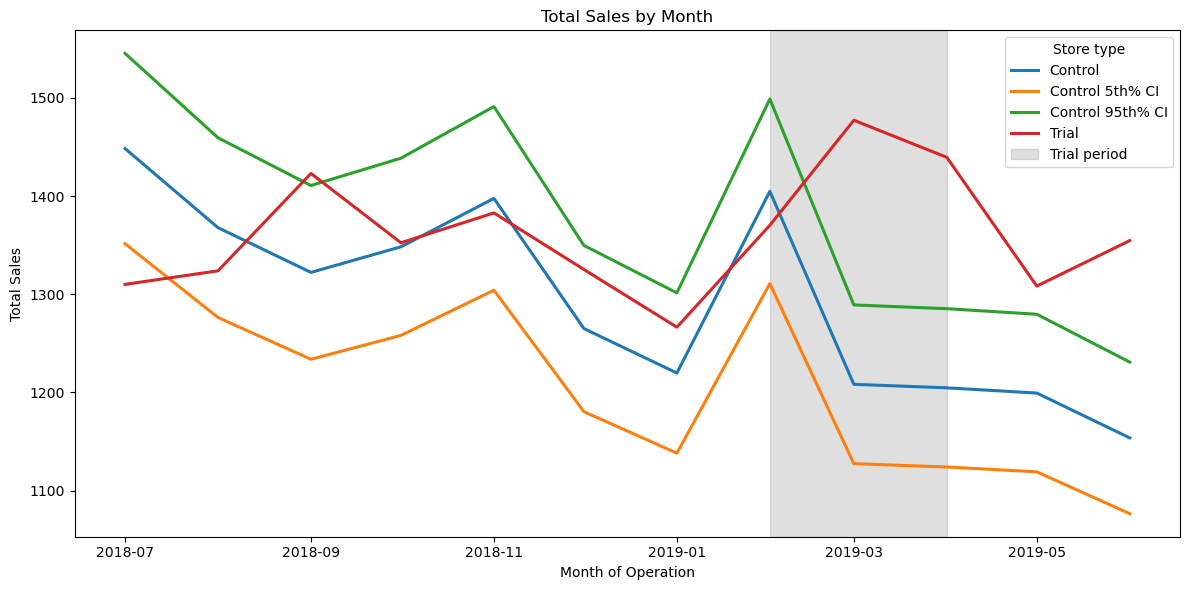

In [360]:
#  1. Calculate scaling factor
scaling_factor_sales = (
    pre_trial_measures[(pre_trial_measures["STORE_NBR"] == trial_store) & (pre_trial_measures["YEARMONTH"] < 201902)]["totSales"].sum()
    / pre_trial_measures[(pre_trial_measures["STORE_NBR"] == control_store) & (pre_trial_measures["YEARMONTH"] < 201902)]["totSales"].sum()
)

#  2. Apply scaling factor to control store sales 
scaledControlSales = measure_over_time.copy()
scaledControlSales.loc[scaledControlSales["STORE_NBR"] == control_store, "controlSales"] = (
    scaledControlSales.loc[scaledControlSales["STORE_NBR"] == control_store, "totSales"] * scaling_factor_sales
)

#  3. Calculate percentage difference 
trial_sales = measure_over_time[measure_over_time["STORE_NBR"] == trial_store][["YEARMONTH", "totSales"]]
control_sales = scaledControlSales[scaledControlSales["STORE_NBR"] == control_store][["YEARMONTH", "controlSales"]]

percentage_diff = pd.merge(control_sales, trial_sales, on="YEARMONTH")
percentage_diff["percentageDiff"] = abs(percentage_diff["controlSales"] - percentage_diff["totSales"]) / percentage_diff["controlSales"]

#  4. Calculate standard deviation in pre-trial period 
std_dev = percentage_diff[percentage_diff["YEARMONTH"] < 201902]["percentageDiff"].std()
degrees_of_freedom = degrees_of_freedom

#  5. Prepare sales data for plotting 
plot_data = measure_over_time.copy()
plot_data["Store_type"] = np.where(plot_data["STORE_NBR"] == trial_store, "Trial",
                          np.where(plot_data["STORE_NBR"] == control_store, "Control", "Otherstores"))

plot_data = plot_data.groupby(["YEARMONTH", "Store_type"]).agg(totSales=("totSales", "mean")).reset_index()
plot_data["TransactionMonth"] = pd.to_datetime(plot_data["YEARMONTH"].astype(str), format="%Y%m")  # e.g. 201807 -> 2018-07-01

# Filter only trial and control
pastSales = plot_data[plot_data["Store_type"].isin(["Trial", "Control"])].copy()

#  6. Create upper and lower bounds for control store
control_upper = pastSales[pastSales["Store_type"] == "Control"].copy()
control_upper["totSales"] *= (1 + 2 * std_dev)
control_upper["Store_type"] = "Control 95th% CI"

control_lower = pastSales[pastSales["Store_type"] == "Control"].copy()
control_lower["totSales"] *= (1 - 2 * std_dev)
control_lower["Store_type"] = "Control 5th% CI"

trialAssessment = pd.concat([pastSales, control_upper, control_lower])

#  7. Plot 
plt.figure(figsize=(12, 6))
for label, grp in trialAssessment.groupby("Store_type"):
    plt.plot(grp["TransactionMonth"], grp["totSales"], label=label, linewidth=2.2)

# Create custom patch for the shaded area (in case it's not picked up by axvspan's label)
trial_patch = mpatches.Patch(color='grey', alpha=0.25, label='Trial period')

# Highlight trial period: Feb to Apr 2019
trial_start = trialAssessment[trialAssessment["YEARMONTH"] == 201902]["TransactionMonth"].min()
trial_end = trialAssessment[trialAssessment["YEARMONTH"] == 201904]["TransactionMonth"].max()

plt.axvspan(trial_start, trial_end, color="grey", alpha=0.25)

plt.title("Total Sales by Month")
plt.xlabel("Month of Operation")
plt.ylabel("Total Sales")
plt.legend(title="Store type", handles=[*plt.gca().get_legend_handles_labels()[0], trial_patch])
plt.tight_layout()
plt.show()


---
#### Insight:
> **Trial store 88** demonstrated a notable increase in total sales during March and April 2019, where performance remained **above the 95% confidence interval** calculated from **control store 237**. Despite being slightly lower in February, the overall sales pattern indicates **a statistically significant improvement in revenue for most of the trial period**. This suggests that the intervention had a strong impact on boosting spending levels, supporting the effectiveness of the trial.
---
#### *Let’s now evaluate whether a similar trend is observed for the number of customers.*

Customer scaling factor: 0.9944
Pre‑trial σ (customers) = 0.0074  |  df = 6


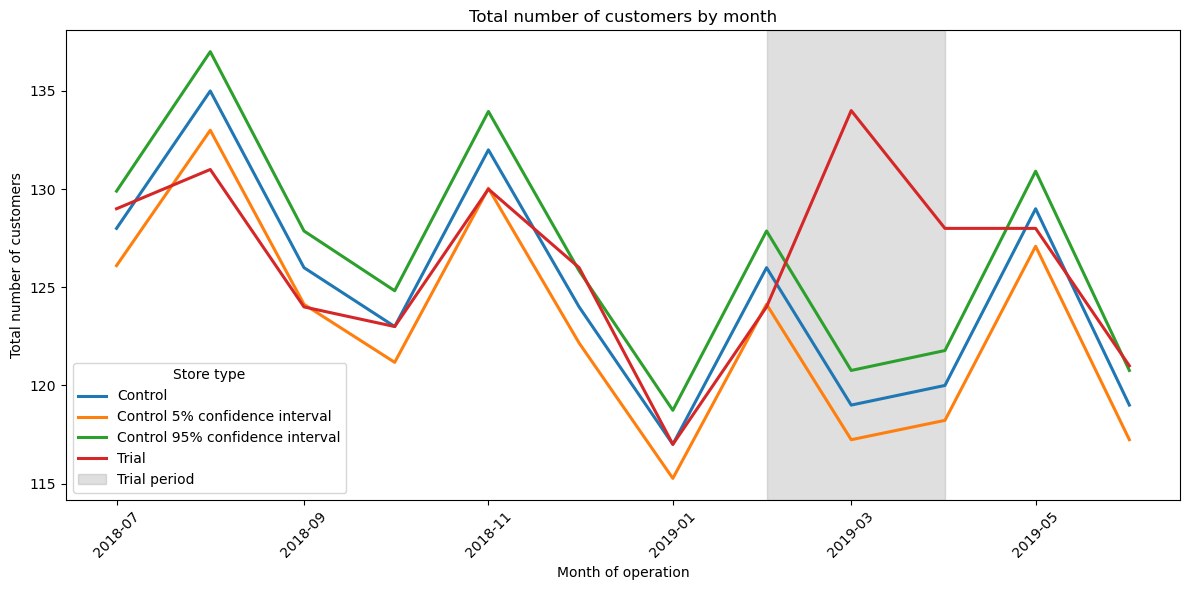

In [361]:
# Scaling factor to line‑up pre‑trial customer counts
trial_pre_cust = pre_trial_measures.loc[
    (pre_trial_measures["STORE_NBR"] == trial_store) &
    (pre_trial_measures["YEARMONTH"] < 201902),
    "nCustomers"
].sum()

control_pre_cust = pre_trial_measures.loc[
    (pre_trial_measures["STORE_NBR"] == control_store) &
    (pre_trial_measures["YEARMONTH"] < 201902),
    "nCustomers"
].sum()

scaling_factor_cust = trial_pre_cust / control_pre_cust
print(f"Customer scaling factor: {scaling_factor_cust:.4f}")

# Apply the scaling factor to every month of the control store
scaled_control_cust = (
    measure_over_time[measure_over_time["STORE_NBR"] == control_store]
      .copy()
)
scaled_control_cust["controlCustomers"] = (
    scaled_control_cust["nCustomers"] * scaling_factor_cust
)

# Percentage‑difference series (Trial vs scaled Control)
trial_cust_series = measure_over_time[
    measure_over_time["STORE_NBR"] == trial_store
][["YEARMONTH", "nCustomers"]]

percentage_diff_cust = (
    pd.merge(
        scaled_control_cust[["YEARMONTH", "controlCustomers"]],
        trial_cust_series,
        on="YEARMONTH"
    )
    .assign(
        percentageDiff=lambda df:
            (df["controlCustomers"] - df["nCustomers"]).abs() /
            df["controlCustomers"]
    )
)

# Std‑dev of %‑diff in the pre‑trial window (< 201902)
std_dev_cust = percentage_diff_cust.loc[
    percentage_diff_cust["YEARMONTH"] < 201902, "percentageDiff"
].std(ddof=1)
degrees_of_freedom = degrees_of_freedom
print(f"Pre‑trial σ (customers) = {std_dev_cust:.4f}  |  df = {degrees_of_freedom}")

# Build monthly averages for plotting
cust_df = measure_over_time.copy()
cust_df["Store_type"] = np.select(
    [cust_df["STORE_NBR"] == trial_store,
     cust_df["STORE_NBR"] == control_store],
    ["Trial", "Control"],
    default="Otherstores"
)

past_customers = (
    cust_df.groupby(["YEARMONTH", "Store_type"], as_index=False)["nCustomers"]
           .mean()
           .rename(columns={"nCustomers": "nCusts"})
)
past_customers["TransactionMonth"] = pd.to_datetime(
    past_customers["YEARMONTH"].astype(str), format="%Y%m"
)

# Filter to Trial & Control rows only
past_customers = past_customers[past_customers["Store_type"].isin(["Trial", "Control"])]

# Add multiplicative ± 2 σ bounds for Control
upper = past_customers[past_customers["Store_type"] == "Control"].copy()
lower = upper.copy()
upper["nCusts"] *= (1 + 2 * std_dev_cust)
upper["Store_type"] = "Control 95% confidence interval"
lower["nCusts"] *= (1 - 2 * std_dev_cust)
lower["Store_type"] = "Control 5% confidence interval"

trial_assessment = pd.concat([past_customers, upper, lower], ignore_index=True)

# Plot
plt.figure(figsize=(12, 6))

# Shade trial period (Feb–Apr 2019)
trial_start = trial_assessment[trial_assessment["YEARMONTH"] == 201902]["TransactionMonth"].min()
trial_end = trial_assessment[trial_assessment["YEARMONTH"] == 201904]["TransactionMonth"].max()

plt.axvspan(trial_start, trial_end, color="grey", alpha=0.25)

# Plot each line
for label, grp in trial_assessment.groupby("Store_type"):
    plt.plot(grp["TransactionMonth"], grp["nCusts"], label=label, linewidth=2.2)

# Create custom patch for the shaded area (in case it's not picked up by axvspan's label)
trial_patch = mpatches.Patch(color='grey', alpha=0.25, label='Trial period')

plt.title("Total number of customers by month")
plt.xlabel("Month of operation")
plt.ylabel("Total number of customers")
plt.xticks(rotation=45)
plt.legend(title="Store type", handles=[*plt.gca().get_legend_handles_labels()[0], trial_patch])
plt.tight_layout()
plt.show()


---
#### Insight:

> Store **88** experienced a steady increase in customer numbers throughout the trial period, consistently **exceeding** the upper bound of the ***95% confidence interval*** derived from **control store 237**, except in beginning of February when the count dipped slightly below expectations. This trend indicates that the trial had a strong and statistically meaningful influence on boosting customer visits, suggesting the initiative was effective in driving greater foot traffic than would typically be observed under normal store conditions.
---